In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
import requests
from io import BytesIO
from zipfile import ZipFile
from neo4j_parallel_spark_loader.bipartite import group_and_batch_spark_dataframe
from neo4j_parallel_spark_loader import ingest_spark_dataframe
from neo4j_parallel_spark_loader.visualize import create_ingest_heatmap


## Create spark session
Update the values below for your environment

In [2]:
username = "NEO4J_USER"
password = "NEO4J_PASSWORD"
url = "NEO4J_URL"
dbname = "NEO4J_DATABASE"
spark_executor_count=5

spark = (
    SparkSession.builder
    .appName("AmazonRatings")
    .config("neo4j.url", url)
    .config("url", url)
    .config("neo4j.authentication.basic.username", username)
    .config("neo4j.authentication.basic.password", password)
    .config("neo4j.database", dbname)
    .getOrCreate()
)

25/01/12 10:50:29 WARN Utils: Your hostname, Nathans-MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 192.168.86.181 instead (on interface en0)
25/01/12 10:50:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/12 10:50:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Download data

In [3]:
# Define the schema
schema = StructType([
    StructField("source_id", IntegerType(), True),
    StructField("target_id", IntegerType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", IntegerType(), True)
])

# Download the ZIP file
response = requests.get("https://nrvis.com/download/data/dynamic/rec-amazon-ratings.zip")
zip_file = ZipFile(BytesIO(response.content))

# Read the CSV file directly from the ZIP
with zip_file.open("rec-amazon-ratings.edges") as file:
    # Convert to string buffer for Spark to read
    content = file.read().decode('utf-8')
    
    # Create RDD from content
    rdd = spark.sparkContext.parallelize(content.splitlines())
    
    # Convert RDD to DataFrame with schema
    rating_df = spark.read.csv(rdd, schema=schema, header=False)

# Now df is your Spark DataFrame containing the data with proper column names and types
# You can verify the data
rating_df.show()
rating_df.printSchema()

25/01/12 10:50:44 WARN TaskSetManager: Stage 0 contains a task of very large size (20312 KiB). The maximum recommended task size is 1000 KiB.


+---------+---------+------+----------+
|source_id|target_id|rating| timestamp|
+---------+---------+------+----------+
|        1|        1|   5.0|1117404000|
|        1|        2|   1.0|1105916400|
|        1|        3|   5.0|1105916400|
|        1|        4|   1.0|1105570800|
|        1|        5|   1.0|1104966000|
|        1|        6|   5.0|1103497200|
|        1|        7|   4.0|1081461600|
|        1|        8|   5.0|1074985200|
|        1|        9|   5.0|1071961200|
|        1|       10|   1.0|1071788400|
|        1|       11|   4.0|1071702000|
|        1|       12|   5.0|1070492400|
|        1|       13|   5.0|1070319600|
|        1|       14|   5.0|1066514400|
|        1|       15|   4.0|1066341600|
|        1|       16|   5.0|1066341600|
|        1|       17|   5.0|1066168800|
|        1|       18|   2.0|1065996000|
|        1|       19|   5.0|1065909600|
|        1|       20|   5.0|1065650400|
+---------+---------+------+----------+
only showing top 20 rows

root
 |-- sour

25/01/12 10:50:49 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


In [4]:
rating_df.count()

25/01/12 10:50:49 WARN TaskSetManager: Stage 1 contains a task of very large size (20312 KiB). The maximum recommended task size is 1000 KiB.


5838041

## Load nodes

In [ ]:
(
    rating_df
    .select("source_id")
    .distinct()
    .write
    .format("org.neo4j.spark.DataSource")
    .mode("Overwrite")
    .option("labels", ":Source")
    .option("node.keys", "source_id:id")
    .option("schema.optimization.node.keys", "KEY")
    .save()
)

In [ ]:
(
    rating_df
    .select("target_id")
    .distinct()
    .write
    .format("org.neo4j.spark.DataSource")
    .mode("Overwrite")
    .option("labels", ":Target")
    .option("node.keys", "target_id:id")
    .option("schema.optimization.node.keys", "KEY")
    .save()
)

## Load rels

In [5]:
rel_batch_df = group_and_batch_spark_dataframe(spark_dataframe=rating_df, 
                                               source_col='source_id', 
                                               target_col='target_id', 
                                               num_groups=spark_executor_count)

25/01/12 10:53:29 WARN TaskSetManager: Stage 4 contains a task of very large size (20312 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 10:54:20 WARN TaskSetManager: Stage 12 contains a task of very large size (20312 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 10:54:50 WARN TaskSetManager: Stage 20 contains a task of very large size (20312 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 10:54:55 WARN TaskSetManager: Stage 21 contains a task of very large size (2348 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 10:54:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/12 10:54:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/12 10:54:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/12 10:54:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyVal

In [6]:
rel_batch_df.show()

25/01/12 10:55:16 WARN TaskSetManager: Stage 58 contains a task of very large size (20312 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 10:55:20 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 58 (TID 134): Attempting to kill Python Worker
25/01/12 10:55:20 WARN TaskSetManager: Stage 59 contains a task of very large size (2348 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 10:55:20 WARN PythonRunner: Detected deadlock while completing task 5.0 in stage 58 (TID 139): Attempting to kill Python Worker
25/01/12 10:55:20 WARN PythonRunner: Detected deadlock while completing task 7.0 in stage 58 (TID 141): Attempting to kill Python Worker
25/01/12 10:55:20 WARN PythonRunner: Detected deadlock while completing task 2.0 in stage 58 (TID 136): Attempting to kill Python Worker
25/01/12 10:55:20 WARN PythonRunner: Detected deadlock while completing task 1.0 in stage 58 (TID 135): Attempting to kill Python Worker
25/01/12 10:55:20 WARN PythonR

+---------+---------+------+----------+-------+-----+
|source_id|target_id|rating| timestamp|  group|batch|
+---------+---------+------+----------+-------+-----+
|        1|        7|   4.0|1081461600|4 --> 4|    3|
|        1|       19|   5.0|1065909600|4 --> 2|    1|
|    41421|     3243|   1.0|1113256800|2 --> 1|    3|
|    16832|     5177|   1.0|1097532000|1 --> 3|    4|
|   636810|     8321|   2.0| 955058400|4 --> 1|    0|
|    16831|    18546|   5.0| 956008800|3 --> 4|    2|
|  1673392|    36750|   1.0|1139094000|0 --> 3|    3|
|    16831|    42744|   4.0|1008284400|3 --> 3|    1|
|    16831|    44234|   5.0| 984956400|3 --> 0|    3|
|  1197279|    79793|   5.0|1102114800|2 --> 2|    4|
|    41420|    85397|   5.0|1043708400|0 --> 4|    4|
|   636807|   131380|   5.0| 943225200|4 --> 1|    0|
|   236796|   220160|   5.0|1126303200|3 --> 2|    0|
|   236796|   237793|   5.0|1144188000|3 --> 1|    4|
|   636818|   420727|   1.0|1138057200|0 --> 1|    1|
|   236796|   497225|   5.0|

25/01/12 10:55:23 WARN TaskSetManager: Stage 69 contains a task of very large size (20312 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 10:55:28 WARN TaskSetManager: Stage 70 contains a task of very large size (2348 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 10:55:29 WARN TaskSetManager: Stage 71 contains a task of very large size (1339 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 10:55:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/12 10:55:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/12 10:55:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/12 10:55:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/12 10:55:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill bu

<Axes: title={'center': 'Parallel Ingest Heat Map'}, xlabel='Group Number', ylabel='Batch'>

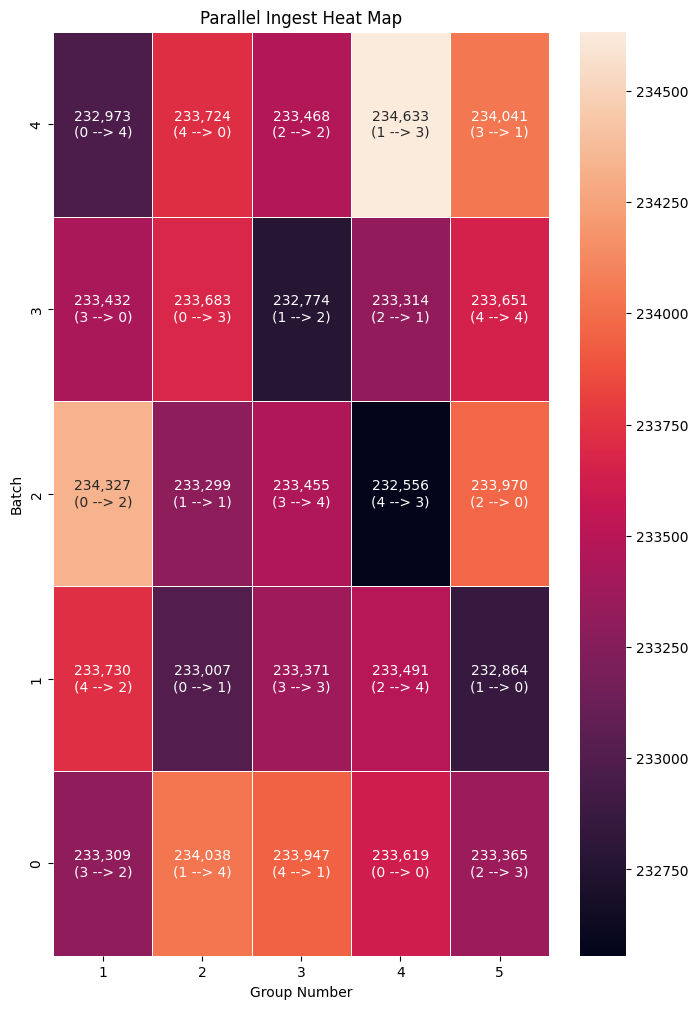

In [7]:
create_ingest_heatmap(rel_batch_df)

In [ ]:
query = """
    MATCH(source:Source {id: event.source_id})
    MATCH(target:Target {id: event.target_id})
    MERGE(source)-[r:RELATES_TO {timestamp:event.timestamp}]->(target)
    SET r.rating = event.rating
    """

ingest_spark_dataframe(
    spark_dataframe=rel_batch_df,
    save_mode= "Overwrite",
    options={"query":query}
)

## Delete rels

In [ ]:
rel_count = rating_df.count()
batch_count = rel_count // 10000 + 1
print(rel_count, batch_count)

In [ ]:
from pyspark.sql.functions import lit
del_df = (spark.range(batch_count)
    .select(lit(1).alias("id")))
print(del_df.count())

In [ ]:
del_query = """
    MATCH ()-[r:RELATES_TO]->()
    WITH r LIMIT 10000
    DELETE r"""

(
    del_df.coalesce(1).write
    .format("org.neo4j.spark.DataSource")
    .mode("Overwrite")
    .option("query", del_query)
    .option("batch.size", 1)
    .save()
)

## Load rels serially

In [ ]:
(
    rating_df.repartition(1).write
    .format("org.neo4j.spark.DataSource")
    .mode("Overwrite")
    .option("query", query)
    .save()
)